# Simple SARAS and Q-learning sample

Simple SARAS and Q-learning sample program of the example problem in the book, [これからの強化学習](https://www.amazon.co.jp/%E3%81%93%E3%82%8C%E3%81%8B%E3%82%89%E3%81%AE%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E7%89%A7%E9%87%8E-%E8%B2%B4%E6%A8%B9/dp/4627880316) Section 1.3

![](./images/environment.png)

## Preparation

In [32]:
import sys
print(sys.version)

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 12:57:14) 
[GCC 7.3.0]


In [33]:
# Global variables
states = {
    's1':['s3', 's2'],
    's2':['s1', 's4'],
    's3':['s4', 's1'],
    's4':[],
}

states_list = ['s1', 's2', 's3', 's4'] # just for using index() function

actions = ['a1', 'a2']

In [34]:
# Environment class
class Environment:
    
    def state_transition(self, current_state, current_action):
        if current_state != 's4':
            action_idx = actions.index(current_action)
            
            next_state = states[current_state][action_idx]
            transition_probability = 1.0
            
            return next_state, transition_probability
            
        else:
            print('Invalid input...')
        
        
    def reward_function(self, current_state, current_action, next_state):
        if current_state == 's1':
            if current_action == 'a1' and next_state == 's3':
                return 0
            if current_action == 'a2' and next_state == 's2':
                return 1
            
        elif current_state == 's2':
            if current_action == 'a1' and next_state == 's1':
                return -1
            if current_action == 'a2' and next_state == 's4':
                return 1 
            
        elif current_state == 's3':
            if current_action == 'a1' and next_state == 's4':
                return 5
            if current_action == 'a2' and next_state == 's1':
                return -100
            
        else:
            print('Invalid input...')

In [35]:
# Agent class
class Agent:
    
    def __init__(self, a1_probability):
        self.a1_probability = a1_probability
        
        
    def policy(self, state):
        if state != 's4':
            weights = [self.a1_probability, 1.0-self.a1_probability]
            action_idx = random.choices(range(len(actions)), weights)[0]

            action = actions[action_idx]
            policy_probability = weights[action_idx]

            return action, policy_probability
        
        else:
            print('Invalid input...')

## Test

In [43]:
Env = Environment()
Agt = Agent(a1_probability=0.95)

for i in range(10):
    current_state = 's1'
    current_action, policy_probability = Agt.policy(current_state)
    next_state, transition_probability = Env.state_transition(current_state, current_action)
    reward = Env.reward_function(current_state, current_action, next_state)
    
    print('current_state =', current_state,
          ', current_action =', current_action, '(', policy_probability, ')',
          ', next_state =', next_state, '(', transition_probability, ')',
          ', reward =', reward)

current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a2 ( 0.050000000000000044 ) , next_state = s2 ( 1.0 ) , reward = 1
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0
current_state = s1 , current_action = a1 ( 0.95 ) , next_state = s3 ( 1.0 ) , reward = 0


## SARAS

In [37]:
# SARAS algorithm
def SARAS(Env, Agt, episode):
    learning_rate = 0.01
    discount_rate = 0.8
    Q = 10 * np.ones((len(states)-1, len(actions))) # Init all Q values by 10
    Q_history = np.empty((len(states)-1, len(actions), 0))
    
    max_step = 100
    
    for i in range(episode):
        step = 0
        current_state = 's1'

        while step < max_step:
            current_s_idx = states_list.index(current_state)
            
            current_action, _ = Agt.policy(current_state) # `policy_probability` is not used
            current_a_idx = actions.index(current_action)
            
            next_state, _ = Env.state_transition(current_state, current_action) # `transition_probability` is not used
            next_s_idx = states_list.index(next_state)
            
            reward = Env.reward_function(current_state, current_action, next_state)

            # When the agent reaches the goal, end the episode
            if next_state == 's4':
                Q[current_s_idx, current_a_idx] = reward
                break;
                
            # Select a next action based on the policy probability 
            next_action, _ = Agt.policy(next_state)
            next_a_idx = actions.index(next_action)

            Q[current_s_idx, current_a_idx] += \
                learning_rate*(reward + discount_rate*Q[next_s_idx, next_a_idx] - Q[current_s_idx, current_a_idx])

            current_state = next_state
            step += 1

        Q_history = np.append(Q_history, Q.reshape((3,2,1)), axis=2)

    plt.title('SARAS')
    plt.plot(range(episode), Q_history[states_list.index('s1'), actions.index('a1')], label='Q(s1, a1)')
    plt.plot(range(episode), Q_history[states_list.index('s1'), actions.index('a2')], label='Q(s1, a2)')
    #plt.plot(range(episode), Q_history[states_list.index('s2'), actions.index('a1')], label='Q(s2, a1)')
    #plt.plot(range(episode), Q_history[states_list.index('s2'), actions.index('a2')], label='Q(s2, a2)')
    #plt.plot(range(episode), Q_history[states_list.index('s3'), actions.index('a1')], label='Q(s3, a1)')
    #plt.plot(range(episode), Q_history[states_list.index('s3'), actions.index('a2')], label='Q(s3, a2)')
    plt.legend(loc=3)
    plt.xlabel('episode')
    plt.ylabel('Q')
    plt.ylim(-60, 10)
    plt.show()

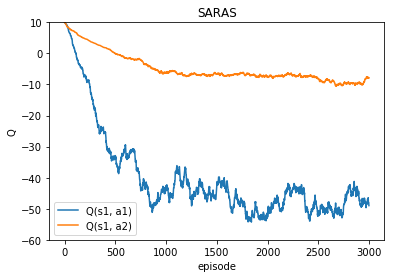

a1_probability = 0.5 




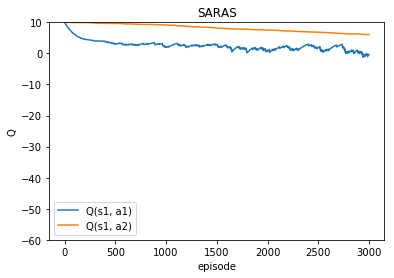

a1_probability = 0.95 




In [38]:
Env = Environment()

a1_probability=0.5
Agt1 = Agent(a1_probability)
SARAS(Env, Agt1, episode=3000)
print('a1_probability =', a1_probability, '\n\n')

a1_probability=0.95
Agt2 = Agent(a1_probability)
SARAS(Env, Agt2, episode=3000)
print('a1_probability =', a1_probability, '\n\n')

![](./images/saras.png)

## Q-learning

In [39]:
# Q-learning algorithm
def Qlearning(Env, Agt, episode):
    learning_rate = 0.01
    discount_rate = 0.8
    Q = 10 * np.ones((len(states)-1, len(actions))) # Init all Q values by 10
    Q_history = np.empty((len(states)-1, len(actions), 0))

    max_step = 100

    for i in range(episode):
        step = 0
        current_state = 's1'

        while step < max_step:
            current_s_idx = states_list.index(current_state)
            
            current_action, _ = Agt.policy(current_state) # `policy_probability` is not used
            current_a_idx = actions.index(current_action)
            
            next_state, _ = Env.state_transition(current_state, current_action) # `transition_probability` is not used
            next_s_idx = states_list.index(next_state)
            
            reward = Env.reward_function(current_state, current_action, next_state)

            # When the agent reaches the goal, end the episode
            if next_state == 's4':
                Q[current_s_idx, current_a_idx] = reward
                break;
                
            # Select a next action which currently gives the best value in the next state   
            next_a_idx = np.argmax(Q[next_s_idx, : ])

            Q[current_s_idx, current_a_idx] += \
                learning_rate*(reward + discount_rate*Q[next_s_idx, next_a_idx] - Q[current_s_idx, current_a_idx])

            current_state = next_state
            step += 1

        Q_history = np.append(Q_history, Q.reshape((3,2,1)), axis=2)

    plt.title('Q-learning')
    plt.plot(range(episode), Q_history[states_list.index('s1'), actions.index('a1')], label='Q(s1, a1)')
    plt.plot(range(episode), Q_history[states_list.index('s1'), actions.index('a2')], label='Q(s1, a2)')
    #plt.plot(range(episode), Q_history[states_list.index('s2'), actions.index('a1')], label='Q(s2, a1)')
    #plt.plot(range(episode), Q_history[states_list.index('s2'), actions.index('a2')], label='Q(s2, a2)')
    #plt.plot(range(episode), Q_history[states_list.index('s3'), actions.index('a1')], label='Q(s3, a1)')
    #plt.plot(range(episode), Q_history[states_list.index('s3'), actions.index('a2')], label='Q(s3, a2)')
    plt.legend(loc=3)
    plt.xlabel('episode')
    plt.ylabel('Q')
    plt.ylim(2, 11)
    plt.show()

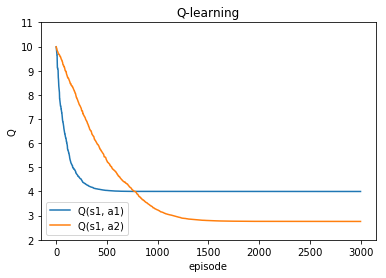

a1_probability = 0.5 




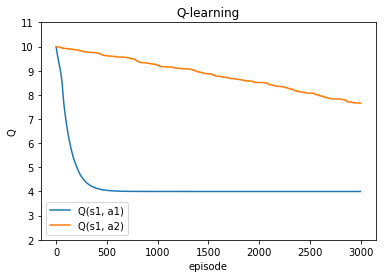

a1_probability = 0.95 




In [40]:
Env = Environment()

a1_probability=0.5
Agt1 = Agent(a1_probability)
Qlearning(Env, Agt1, episode=3000)
print('a1_probability =', a1_probability, '\n\n')

a1_probability=0.95
Agt2 = Agent(a1_probability)
Qlearning(Env, Agt2, episode=3000)
print('a1_probability =', a1_probability, '\n\n')

![](./images/q-learning.png)

To see the converged value of `Q(s1, a2)` when `a1_probability = 0.95` is same as the one when `a1_probability = 0.5`, just run the loop with more episodes.

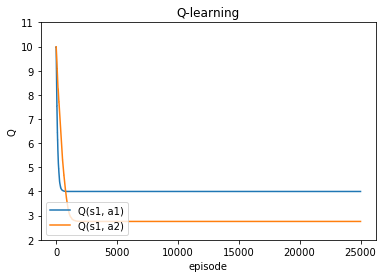

a1_probability = 0.5 




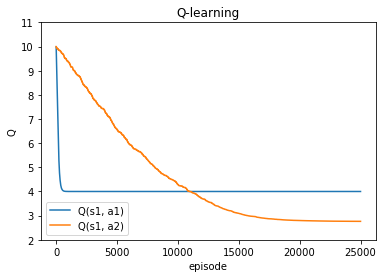

a1_probability = 0.95 




In [41]:
Env = Environment()

a1_probability=0.5
Agt1 = Agent(a1_probability)
Qlearning(Env, Agt1, episode=25000)
print('a1_probability =', a1_probability, '\n\n')

a1_probability=0.95
Agt2 = Agent(a1_probability)
Qlearning(Env, Agt2, episode=25000)
print('a1_probability =', a1_probability, '\n\n')

The `Q(s1, a2)` converged to same value both when `a1_probability = 0.5` and `a1_probability = 0.95`.